# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

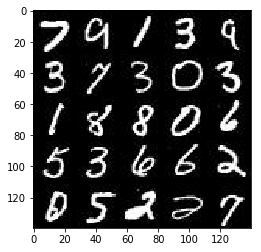

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

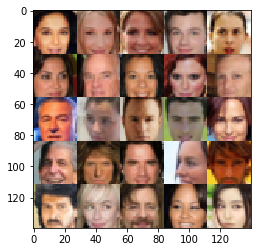

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [64]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, 
                                 (None, image_width, image_height, image_channels),
                                  name='inputs_real')
    inputs_z = tf.placeholder(tf.float32,
                              (None, z_dim),
                              name='inputs_z')
    
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


# Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [106]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    stddev = 0.02
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28
        x1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        relu1 = tf.maximum(alpha*x1, x1)
        #14
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha*bn2, bn2)
        #7
        
        x3 = tf.layers.conv2d(relu2, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha*bn3, bn3)
                
        flat = tf.reshape(relu3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [107]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        alpha = 0.2
        stddev = 0.02
        
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 7

        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        #14
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev) )
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        #28
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same', kernel_initializer=tf.random_normal_initializer(stddev=stddev))
        
        out = tf.tanh(logits)

        return out


    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [108]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake                            
                            
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [109]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    with tf.control_dependencies(g_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [110]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [113]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model    
    size = data_shape[1]
    dim = 3 if data_image_mode=="RGB" else 1
       
    input_real, input_z, var_learning_rate = model_inputs(size, size, dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, var_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                                
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4309... Generator Loss: 0.5248
Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.5270
Epoch 1/2... Discriminator Loss: 1.4943... Generator Loss: 0.7680
Epoch 1/2... Discriminator Loss: 1.3660... Generator Loss: 0.8902
Epoch 1/2... Discriminator Loss: 1.2776... Generator Loss: 0.8220
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.9391
Epoch 1/2... Discriminator Loss: 1.0229... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.1872... Generator Loss: 0.8584
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.1648... Generator Loss: 0.9972


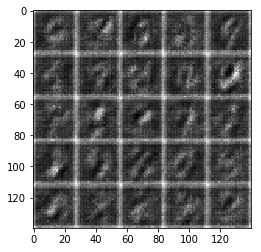

Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 0.9020
Epoch 1/2... Discriminator Loss: 1.1032... Generator Loss: 1.0528
Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 1.1967
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 1.0169
Epoch 1/2... Discriminator Loss: 1.2899... Generator Loss: 1.5200
Epoch 1/2... Discriminator Loss: 1.1453... Generator Loss: 1.2031
Epoch 1/2... Discriminator Loss: 1.1415... Generator Loss: 0.9489
Epoch 1/2... Discriminator Loss: 1.2022... Generator Loss: 0.7670
Epoch 1/2... Discriminator Loss: 1.0733... Generator Loss: 0.9413


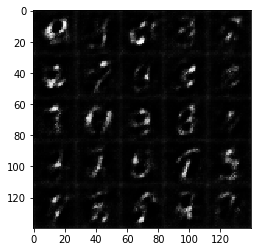

Epoch 1/2... Discriminator Loss: 1.1391... Generator Loss: 0.9479
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.1241
Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 0.8021
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.9800
Epoch 1/2... Discriminator Loss: 1.1438... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.1805... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 1.1035... Generator Loss: 1.2584
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.9375
Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.8704


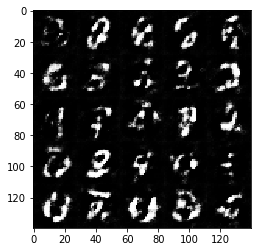

Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.9730
Epoch 1/2... Discriminator Loss: 1.0563... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.0239... Generator Loss: 1.0707
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 1.0584
Epoch 1/2... Discriminator Loss: 1.0511... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.0976... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.0033... Generator Loss: 1.1981
Epoch 1/2... Discriminator Loss: 1.0447... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 1.1202... Generator Loss: 1.7816
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.8237


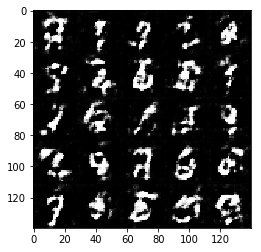

Epoch 1/2... Discriminator Loss: 0.9473... Generator Loss: 1.2361
Epoch 1/2... Discriminator Loss: 1.0069... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 0.9962... Generator Loss: 0.9042
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 0.8862... Generator Loss: 1.3087
Epoch 1/2... Discriminator Loss: 0.8543... Generator Loss: 1.3749
Epoch 1/2... Discriminator Loss: 0.8929... Generator Loss: 1.4575
Epoch 1/2... Discriminator Loss: 0.8718... Generator Loss: 1.5085


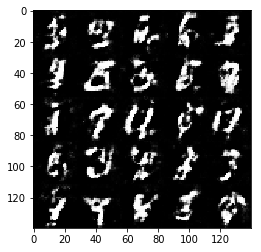

Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 1.0783
Epoch 1/2... Discriminator Loss: 0.8888... Generator Loss: 1.4837
Epoch 1/2... Discriminator Loss: 0.7971... Generator Loss: 1.6429
Epoch 1/2... Discriminator Loss: 0.9192... Generator Loss: 1.0857
Epoch 1/2... Discriminator Loss: 0.8700... Generator Loss: 1.2527
Epoch 1/2... Discriminator Loss: 0.9765... Generator Loss: 0.9120
Epoch 1/2... Discriminator Loss: 0.9037... Generator Loss: 1.4390
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 0.9616
Epoch 1/2... Discriminator Loss: 1.0573... Generator Loss: 0.7977
Epoch 1/2... Discriminator Loss: 0.9205... Generator Loss: 1.5588


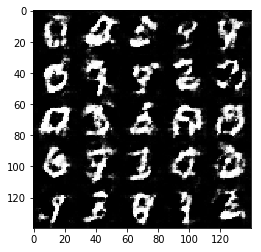

Epoch 1/2... Discriminator Loss: 0.9868... Generator Loss: 1.7117
Epoch 1/2... Discriminator Loss: 1.2017... Generator Loss: 1.8984
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.4087
Epoch 1/2... Discriminator Loss: 0.9487... Generator Loss: 1.1994
Epoch 1/2... Discriminator Loss: 1.0508... Generator Loss: 1.0054
Epoch 1/2... Discriminator Loss: 1.0354... Generator Loss: 0.9962
Epoch 1/2... Discriminator Loss: 0.9710... Generator Loss: 1.4614
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.7578
Epoch 1/2... Discriminator Loss: 1.0486... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 1.0333


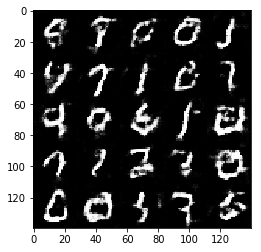

Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7854
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.2530
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 1.1153
Epoch 1/2... Discriminator Loss: 1.0423... Generator Loss: 0.9966
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.4535
Epoch 1/2... Discriminator Loss: 1.0669... Generator Loss: 0.9354
Epoch 1/2... Discriminator Loss: 1.0748... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 1.0318... Generator Loss: 1.1002
Epoch 1/2... Discriminator Loss: 1.0385... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 1.1777... Generator Loss: 1.2391


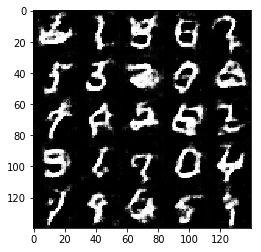

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.9799
Epoch 1/2... Discriminator Loss: 0.9968... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 1.0473... Generator Loss: 1.0978
Epoch 1/2... Discriminator Loss: 1.0243... Generator Loss: 0.8628
Epoch 1/2... Discriminator Loss: 1.1072... Generator Loss: 1.2839
Epoch 1/2... Discriminator Loss: 1.1093... Generator Loss: 0.8387
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 1.1918
Epoch 1/2... Discriminator Loss: 1.0780... Generator Loss: 1.4706
Epoch 1/2... Discriminator Loss: 1.0199... Generator Loss: 1.4849
Epoch 1/2... Discriminator Loss: 1.0319... Generator Loss: 1.1038


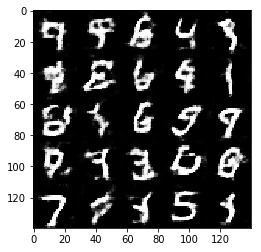

Epoch 1/2... Discriminator Loss: 0.9990... Generator Loss: 1.1618
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 1.0593... Generator Loss: 0.9621
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 1.0217... Generator Loss: 1.1957
Epoch 2/2... Discriminator Loss: 0.9821... Generator Loss: 1.2884
Epoch 2/2... Discriminator Loss: 1.0336... Generator Loss: 1.1807
Epoch 2/2... Discriminator Loss: 1.0003... Generator Loss: 1.3879
Epoch 2/2... Discriminator Loss: 1.1074... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.8404


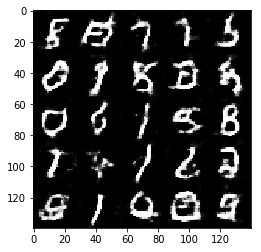

Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.2825
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.3437
Epoch 2/2... Discriminator Loss: 1.0178... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 1.5877
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.0162... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.9198
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.1653
Epoch 2/2... Discriminator Loss: 1.0329... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.0359... Generator Loss: 1.1854


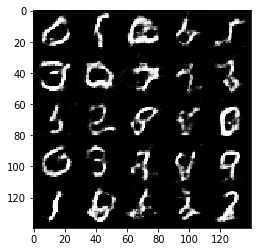

Epoch 2/2... Discriminator Loss: 1.0373... Generator Loss: 1.1621
Epoch 2/2... Discriminator Loss: 0.9985... Generator Loss: 1.0677
Epoch 2/2... Discriminator Loss: 1.0924... Generator Loss: 0.9629
Epoch 2/2... Discriminator Loss: 0.9265... Generator Loss: 1.2446
Epoch 2/2... Discriminator Loss: 1.1452... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 1.0921... Generator Loss: 1.5375
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.9689
Epoch 2/2... Discriminator Loss: 1.1214... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 1.1552... Generator Loss: 0.7433
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 1.3481


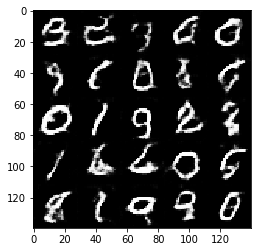

Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 1.0493
Epoch 2/2... Discriminator Loss: 1.0950... Generator Loss: 0.8393
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.0656... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 0.9567
Epoch 2/2... Discriminator Loss: 0.9544... Generator Loss: 1.1698
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 1.3869
Epoch 2/2... Discriminator Loss: 1.0577... Generator Loss: 1.3286
Epoch 2/2... Discriminator Loss: 1.0632... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 1.1374... Generator Loss: 0.7637


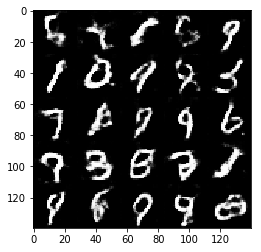

Epoch 2/2... Discriminator Loss: 1.0529... Generator Loss: 1.2339
Epoch 2/2... Discriminator Loss: 1.0158... Generator Loss: 0.8921
Epoch 2/2... Discriminator Loss: 1.0224... Generator Loss: 1.3929
Epoch 2/2... Discriminator Loss: 0.9094... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 0.9744... Generator Loss: 1.5075
Epoch 2/2... Discriminator Loss: 1.0441... Generator Loss: 0.9898
Epoch 2/2... Discriminator Loss: 1.0058... Generator Loss: 1.2030
Epoch 2/2... Discriminator Loss: 0.9493... Generator Loss: 1.3751
Epoch 2/2... Discriminator Loss: 0.9246... Generator Loss: 1.2824
Epoch 2/2... Discriminator Loss: 0.9810... Generator Loss: 1.1781


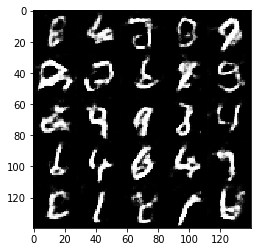

Epoch 2/2... Discriminator Loss: 0.9645... Generator Loss: 1.2877
Epoch 2/2... Discriminator Loss: 0.9899... Generator Loss: 1.3357
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.1455
Epoch 2/2... Discriminator Loss: 0.9088... Generator Loss: 1.0878
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.0263
Epoch 2/2... Discriminator Loss: 0.9293... Generator Loss: 1.2789
Epoch 2/2... Discriminator Loss: 0.9822... Generator Loss: 0.9773
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.9445
Epoch 2/2... Discriminator Loss: 0.9405... Generator Loss: 1.4219


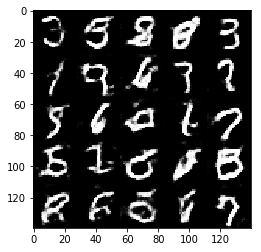

Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.1858
Epoch 2/2... Discriminator Loss: 0.9494... Generator Loss: 1.0254
Epoch 2/2... Discriminator Loss: 1.0880... Generator Loss: 0.7668
Epoch 2/2... Discriminator Loss: 1.0108... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 0.9581... Generator Loss: 1.0431
Epoch 2/2... Discriminator Loss: 1.0617... Generator Loss: 0.8730
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 0.7724
Epoch 2/2... Discriminator Loss: 1.0635... Generator Loss: 1.5757
Epoch 2/2... Discriminator Loss: 0.9393... Generator Loss: 1.4095
Epoch 2/2... Discriminator Loss: 1.0711... Generator Loss: 0.8906


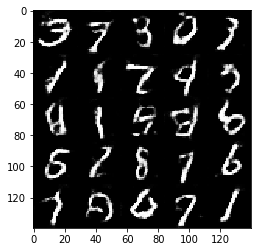

Epoch 2/2... Discriminator Loss: 0.8659... Generator Loss: 1.3359
Epoch 2/2... Discriminator Loss: 1.0912... Generator Loss: 0.8058
Epoch 2/2... Discriminator Loss: 0.9222... Generator Loss: 1.0587
Epoch 2/2... Discriminator Loss: 1.0398... Generator Loss: 0.8648
Epoch 2/2... Discriminator Loss: 1.0322... Generator Loss: 0.8236
Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 1.4866
Epoch 2/2... Discriminator Loss: 1.0599... Generator Loss: 0.7940
Epoch 2/2... Discriminator Loss: 1.0197... Generator Loss: 1.7541
Epoch 2/2... Discriminator Loss: 1.1696... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.2761


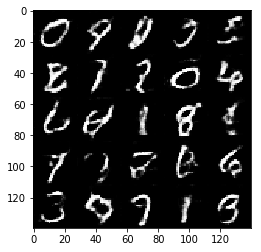

Epoch 2/2... Discriminator Loss: 0.9312... Generator Loss: 0.9822
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.1236
Epoch 2/2... Discriminator Loss: 0.8924... Generator Loss: 1.6722
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 0.9213... Generator Loss: 1.1973
Epoch 2/2... Discriminator Loss: 0.9469... Generator Loss: 0.9473
Epoch 2/2... Discriminator Loss: 1.1404... Generator Loss: 0.7193
Epoch 2/2... Discriminator Loss: 0.9449... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 0.9126... Generator Loss: 1.0578
Epoch 2/2... Discriminator Loss: 0.8634... Generator Loss: 1.2525


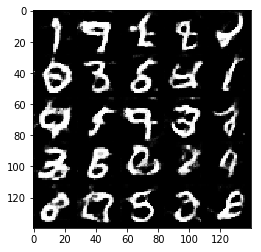

Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.6338
Epoch 2/2... Discriminator Loss: 0.9205... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 0.9564
Epoch 2/2... Discriminator Loss: 1.9339... Generator Loss: 0.2893
Epoch 2/2... Discriminator Loss: 0.9187... Generator Loss: 1.1701
Epoch 2/2... Discriminator Loss: 0.8748... Generator Loss: 1.2680
Epoch 2/2... Discriminator Loss: 0.9813... Generator Loss: 1.1054


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.7321... Generator Loss: 0.4151
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 0.9069... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.8748... Generator Loss: 1.2438
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.1269
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.3078
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.1859


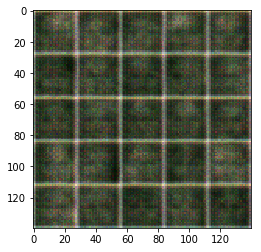

Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.0559
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.9360
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.2529
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9339
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6165


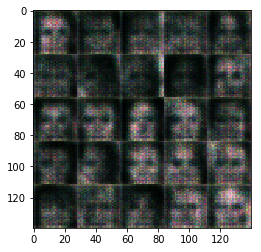

Epoch 1/1... Discriminator Loss: 1.1991... Generator Loss: 1.0317
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.2890... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.2202
Epoch 1/1... Discriminator Loss: 1.1651... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.1590
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.8414


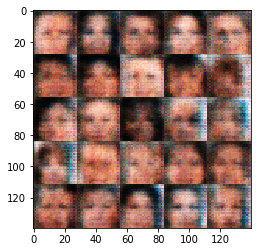

Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.4086
Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.9581
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.0550
Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.0138... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.4871
Epoch 1/1... Discriminator Loss: 1.0601... Generator Loss: 0.9451


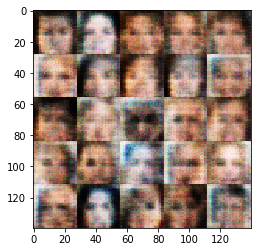

Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 1.0743
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.0685... Generator Loss: 2.0002
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.4181
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 2.5421
Epoch 1/1... Discriminator Loss: 0.9346... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.8889


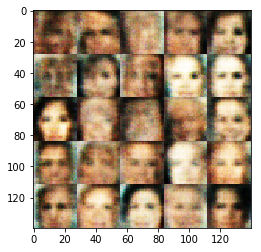

Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.2424
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.8842
Epoch 1/1... Discriminator Loss: 1.0557... Generator Loss: 0.9842
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.1003
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 0.8584... Generator Loss: 1.3168
Epoch 1/1... Discriminator Loss: 0.9036... Generator Loss: 1.1978
Epoch 1/1... Discriminator Loss: 0.9652... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.2120... Generator Loss: 0.7962


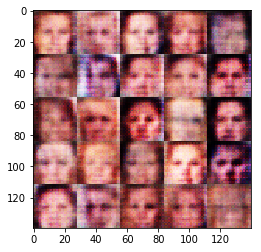

Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.1897
Epoch 1/1... Discriminator Loss: 1.8300... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.9083


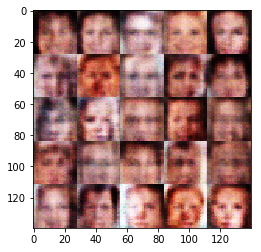

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8001
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.1791
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.2304... Generator Loss: 0.8431
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1710... Generator Loss: 1.0679
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.8661
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7677


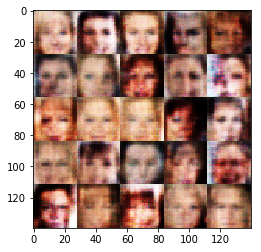

Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6835
Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.9098
Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.9959
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.6479... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.9403


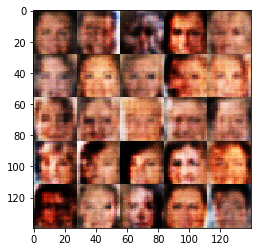

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.5409... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8460


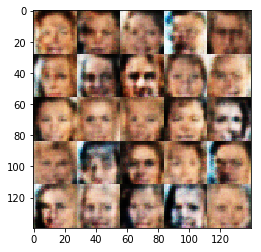

Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8240
Epoch 1/1... Discriminator Loss: 1.2885... Generator Loss: 0.8491
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.9214


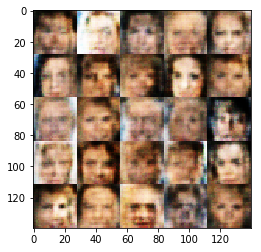

Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8327
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 1.0156
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0420
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 1.2056


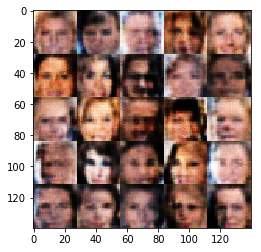

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.5223... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.8017


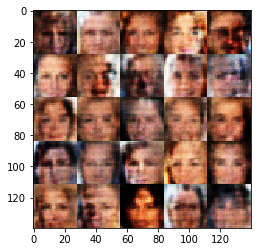

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9225
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.9865
Epoch 1/1... Discriminator Loss: 1.2306... Generator Loss: 0.9112
Epoch 1/1... Discriminator Loss: 1.2992... Generator Loss: 0.9979
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.8535
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.8664
Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.9319


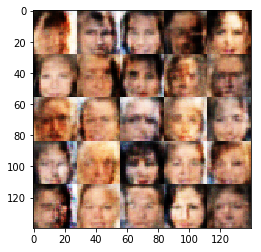

Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.1288... Generator Loss: 0.9454
Epoch 1/1... Discriminator Loss: 1.1501... Generator Loss: 1.0103
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.4805
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.4881
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 1.5632
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0247


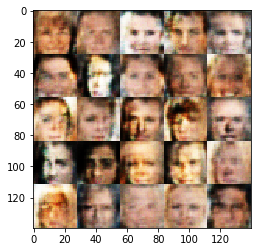

Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 2.3136
Epoch 1/1... Discriminator Loss: 1.0756... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.2050
Epoch 1/1... Discriminator Loss: 1.0878... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.7157
Epoch 1/1... Discriminator Loss: 1.5281... Generator Loss: 1.0641
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 1.0649


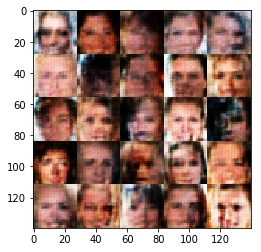

Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.9113
Epoch 1/1... Discriminator Loss: 1.0174... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.4646... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2587... Generator Loss: 0.9317
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.8111


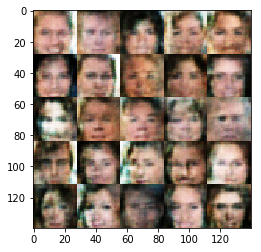

Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.9163
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 1.0563
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.8706
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.0948... Generator Loss: 1.0210
Epoch 1/1... Discriminator Loss: 1.0755... Generator Loss: 0.9271


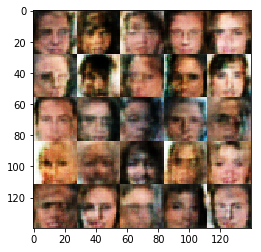

Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.2418... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 1.0644
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 0.8482
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 1.7925
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 1.2052... Generator Loss: 1.1796
Epoch 1/1... Discriminator Loss: 1.1664... Generator Loss: 0.8737


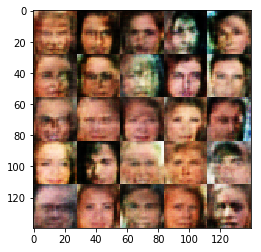

Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.3483... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 1.1636
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.4379
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 1.4885
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.4158
Epoch 1/1... Discriminator Loss: 1.0657... Generator Loss: 0.8078


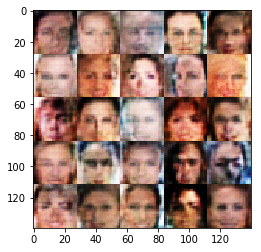

Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 2.4946
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.4795
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.3458
Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 1.5698
Epoch 1/1... Discriminator Loss: 1.1590... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.1951
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7237
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.7599


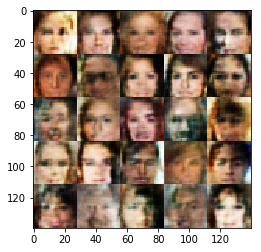

Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 1.0176
Epoch 1/1... Discriminator Loss: 1.2821... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 0.9434... Generator Loss: 1.9440


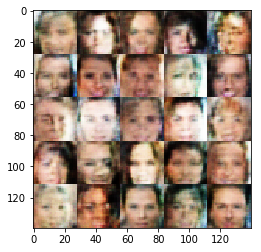

Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 1.3616
Epoch 1/1... Discriminator Loss: 0.9936... Generator Loss: 1.1404
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.8334
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.5332... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.6264... Generator Loss: 0.3761
Epoch 1/1... Discriminator Loss: 1.1652... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3787... Generator Loss: 0.6776


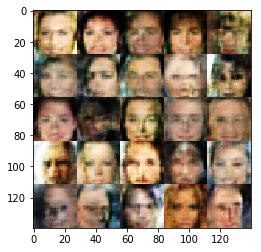

Epoch 1/1... Discriminator Loss: 1.6383... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.5959
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.0524
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.9203
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 1.3838
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.1766... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.8889


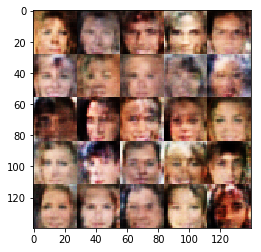

Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.9997
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.9171


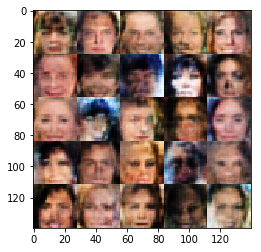

Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8194
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.2954... Generator Loss: 0.8439
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.0245
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9284


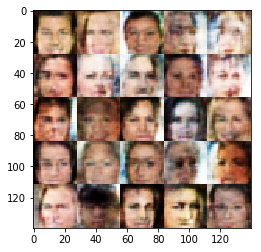

Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.9459
Epoch 1/1... Discriminator Loss: 1.2373... Generator Loss: 1.0134
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8770
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.9448
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.9297
Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7737


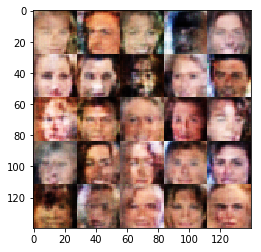

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.1449... Generator Loss: 1.0290
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 1.1075
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.2449... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.7482


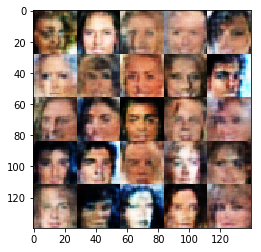

Epoch 1/1... Discriminator Loss: 1.3191... Generator Loss: 0.8052
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 1.0087
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 0.7836


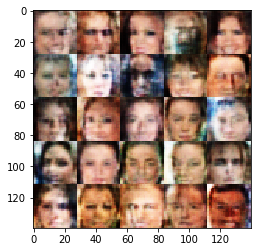

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.1239... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 1.0142
Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9198
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8491


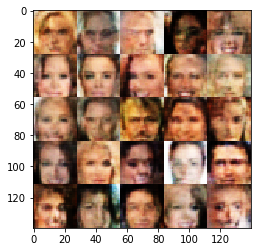

Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.8292
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.2776... Generator Loss: 0.8238
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 1.0746
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.8687
Epoch 1/1... Discriminator Loss: 1.2551... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 0.9253
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6990


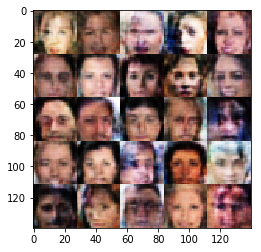

Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.7733
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9211
Epoch 1/1... Discriminator Loss: 1.1469... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.8546


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.